In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import json
import os
import math
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow.keras as keras

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, KFold,GridSearchCV

In [6]:
audio_path = "drive/MyDrive/Data/genres_original/rock/rock.00090.wav"
audio, sr = librosa.load(audio_path)

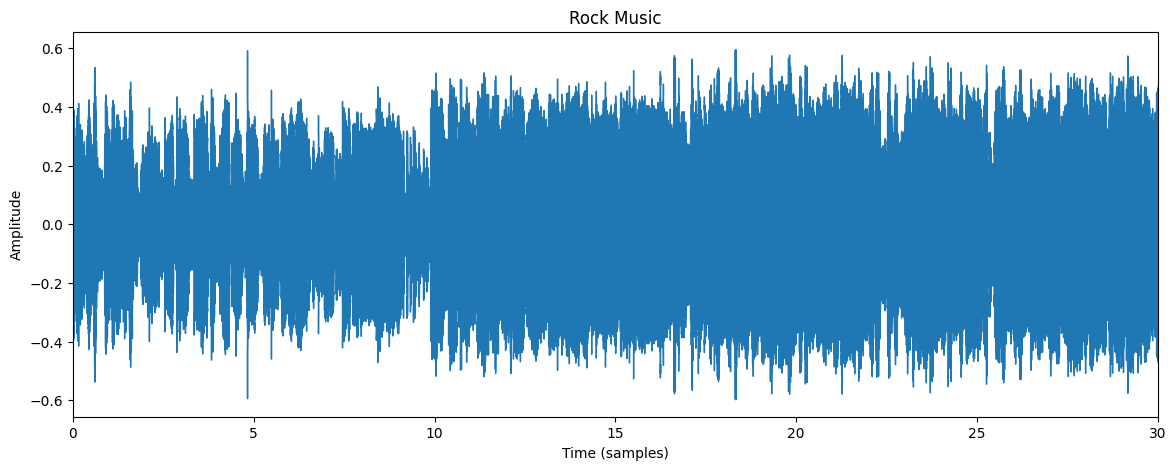

In [7]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio, sr=sr)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Rock Music')
plt.xlim([0,30])
plt.show()

In [1]:
MUSIC_DATASET_PATH = "drive/MyDrive/Data/genres_original"
FEATURES_JSON_PATH = "drive/MyDrive/Data/features.json" #extracted features in JSON format
SAMPLE_RATE = 22050  # Sampling rate
SAMPLES_PER_TRACK = SAMPLE_RATE * 30 # Total number of samples in each track
N_MFCC = 13 # Number of Mel-frequency cepstral coefficients
N_FFT = 2048  # Number of samples in each Fourier transform window
HOP_LENGTH = 512 # Number of samples between successive frames

In [16]:
# Process a single audio file to extract various audio features and store them in a dictionary.

# Parameters:
# audio_path: The path to the audio file being processed.

def extract_features(audio_path):
    audio, sr = librosa.load(audio_path, sr=SAMPLE_RATE) # Load the audio file

    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)  # Extract MFCCs
    mfccs_mean = np.mean(mfccs, axis=1)

    chroma = librosa.feature.chroma_stft(y=audio, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH) # Extract Chroma
    chroma_mean = np.mean(chroma, axis=1)

    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH) # Extract Mel-Spectrogram
    mel_spectrogram_mean = np.mean(mel_spectrogram, axis=1)

    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH) # Extract Spectral
    spectral_contrast_mean = np.mean(spectral_contrast, axis=1)

    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH) # Extract Spectral Roll-off
    spectral_rolloff_mean = np.mean(spectral_rolloff, axis=1)

    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio, hop_length=HOP_LENGTH) # Extract Zero-Crossing Rate
    zero_crossing_rate_mean = np.mean(zero_crossing_rate, axis=1)

    rmse = librosa.feature.rms(y=audio, hop_length=HOP_LENGTH)# Extract Root Mean Square Energy
    rmse_mean = np.mean(rmse, axis=1)

    features = {
        'mfccs_mean': mfccs_mean.tolist(),
        'chroma_mean': chroma_mean.tolist(),
        'mel_spectrogram_mean': mel_spectrogram_mean.tolist(),
        'spectral_contrast_mean': spectral_contrast_mean.tolist(),
        'spectral_rolloff_mean': spectral_rolloff_mean.tolist(),
        'zero_crossing_rate_mean': zero_crossing_rate_mean.tolist(),
        'rmse_mean': rmse_mean.tolist()
    }
    return features


In [ ]:
#Process the entire dataset to extract features from all audio files and store them.

#Parameters:
#dataset_path: The path to the dataset containing music files organized in genre folders.

def process_dataset(dataset_path):
    features_list = []

    for genre in os.listdir(dataset_path):
        genre_path = os.path.join(dataset_path, genre)
        if not os.path.isdir(genre_path):
            continue
        for file in os.listdir(genre_path): # Iterate over each audio file
            if file.endswith('.wav'):
                file_path = os.path.join(genre_path, file)
                features = extract_features(file_path)
                features['genre'] = genre # Adds the genre label to the features dictionary
                features_list.append(features)
                print(f"Processed {file_path}")

    return features_list

In [ ]:
#Save the extracted features to a JSON file
#Parameters:
#features: A list of dictionaries, each containing the extracted features and the genre label of an audio file.
#json_path: The path where the JSON file will be saved.

def save_features_to_json(features, json_path):
    for feature_entry in features:
        for feature in feature_entry:
            if isinstance(feature_entry[feature], np.ndarray): # Convert numpy arrays to lists for JSON serialization
                feature_entry[feature] = feature_entry[feature].tolist()

    with open(json_path, "w") as fp:# Write the features list to a JSON file
        json.dump(features, fp, indent=4)


In [ ]:
# process dataset and extract features
features = process_dataset(MUSIC_DATASET_PATH)


Processed drive/MyDrive/Data/genres_original/jazz/jazz.00005.wav
Processed drive/MyDrive/Data/genres_original/jazz/jazz.00002.wav
Processed drive/MyDrive/Data/genres_original/jazz/jazz.00004.wav
Processed drive/MyDrive/Data/genres_original/jazz/jazz.00003.wav
Processed drive/MyDrive/Data/genres_original/jazz/jazz.00001.wav
Processed drive/MyDrive/Data/genres_original/jazz/jazz.00007.wav
Processed drive/MyDrive/Data/genres_original/jazz/jazz.00006.wav
Processed drive/MyDrive/Data/genres_original/jazz/jazz.00000.wav
Processed drive/MyDrive/Data/genres_original/jazz/jazz.00025.wav
Processed drive/MyDrive/Data/genres_original/jazz/jazz.00018.wav
Processed drive/MyDrive/Data/genres_original/jazz/jazz.00013.wav
Processed drive/MyDrive/Data/genres_original/jazz/jazz.00015.wav
Processed drive/MyDrive/Data/genres_original/jazz/jazz.00023.wav
Processed drive/MyDrive/Data/genres_original/jazz/jazz.00014.wav
Processed drive/MyDrive/Data/genres_original/jazz/jazz.00032.wav
Processed drive/MyDrive/D

In [ ]:
#Save all features to json file.
save_features_to_json(features, FEATURES_JSON_PATH)

In [8]:
#Load data from a JSON file.
#Parameters:
#data_path: The path to the data file.
def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    return data

In [9]:
data= load_data(FEATURES_JSON_PATH)

In [80]:
# Prepare the dataset.
# X: Features array y: Labels array
X = np.array([entry['mfccs_mean'] + entry['chroma_mean'] + entry['mel_spectrogram_mean'] +
              entry['spectral_contrast_mean'] + entry['spectral_rolloff_mean'] +
              entry['zero_crossing_rate_mean'] + entry['rmse_mean'] for entry in data])
y = np.array([entry['genre'] for entry in data])

In [81]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:
# KNN MODEL

param_grid = { # Define the parameter grid for grid search
    'n_neighbors': np.arange(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=5) # Perform grid search with cross-validation
knn_cv.fit(X_train_scaled, y_train)

print("Best parameters:", knn_cv.best_params_)


scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']  # Define scoring metrics for cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize KNN model with best parameters
knn_model = KNeighborsClassifier(n_neighbors=knn_cv.best_params_['n_neighbors'],
                                weights=knn_cv.best_params_['weights'],
                                metric=knn_cv.best_params_['metric'])

# cross-validation
cv_results = cross_validate(knn_model, X, y, cv=kfold, scoring=scoring)

for metric in scoring:
    print(metric, ": ", cv_results['test_' + metric].mean())

knn_model.fit(X_train_scaled, y_train) # Fit the KNN model on the training data

accuracy = knn_model.score(X_test_scaled, y_test)
print("KNN Accuracy:", accuracy)

Best parameters: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}
accuracy :  0.4474824120603015
precision_weighted :  0.4760014817103023
recall_weighted :  0.4474824120603015
f1_weighted :  0.44935979811708665
KNN Accuracy: 0.655


In [ ]:
# RANDOMFOREST BEST PARAMETERS

param_grid = { # Define the parameter grid for grid search
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)

rf_cv = GridSearchCV(rf, param_grid, cv=5) # Perform grid search with cross-validation
rf_cv.fit(X_train_scaled, y_train)

print("Best parameters:", rf_cv.best_params_)



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

KeyboardInterrupt: 

In [82]:
# RANDOMFOREST CUSTOM PARAMETERS

custom_params = {
    'n_estimators': 200,
    'max_depth': 25,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt'
}

# Create a RandomForestClassifier instance with custom parameters
rf_custom = RandomForestClassifier(**custom_params, random_state=42)

# Train the model
rf_custom.fit(X_train_scaled, y_train)

accuracy = rf_custom.score(X_test_scaled, y_test)
print("Test set accuracy with custom parameters:", accuracy)

Test set accuracy with custom parameters: 0.695


In [89]:
import librosa

#external_audio_path = "drive/MyDrive/Data/genres_original/blues/blues.00001.wav"
external_audio_path = "drive/MyDrive/Data/eminem.wav"

features = extract_features(external_audio_path) #extract features from test audio

# input for the model
input_features = np.array(features['mfccs_mean'] + features['chroma_mean'] + features['mel_spectrogram_mean'] +
                         features['spectral_contrast_mean'] + features['spectral_rolloff_mean'] +
                         features['zero_crossing_rate_mean'] + features['rmse_mean']).reshape(1, -1)

new_sample_scaled = scaler.transform(input_features)
predicted_class = knn_model.predict(new_sample_scaled)
print("KNN Predicted:", predicted_class)

predict = rf_custom.predict(new_sample_scaled)
print("RF Predicted:", predict)


KNN Predicted: ['pop']
RF Predicted: ['pop']


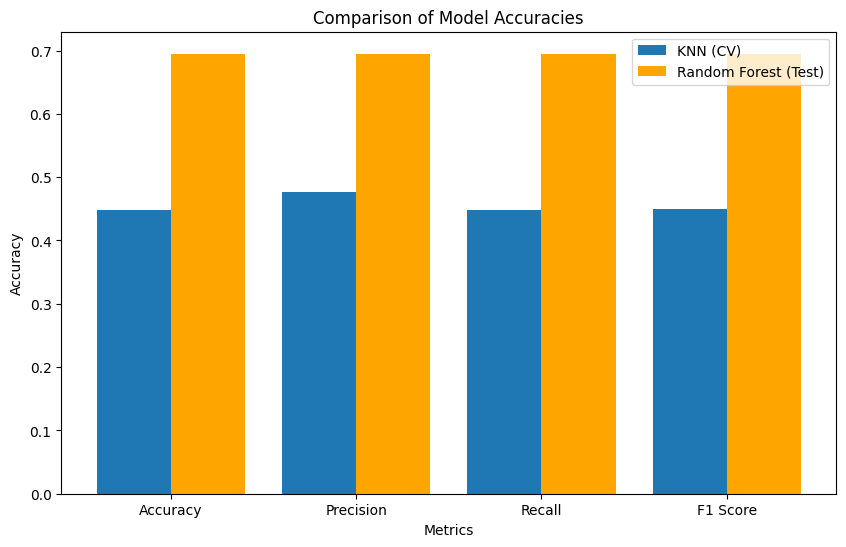

In [20]:
# Extract accuracy values
knn_accuracies_cv = [cv_results['test_accuracy'].mean(), cv_results['test_precision_weighted'].mean(),
                     cv_results['test_recall_weighted'].mean(), cv_results['test_f1_weighted'].mean()]
rf_accuracy_test = accuracy

# Define the evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Plotting
plt.figure(figsize=(10, 6))

# Plot KNN accuracy values
plt.bar(np.arange(len(metrics))-0.2, knn_accuracies_cv, width=0.4, label='KNN (CV)')
# Plot Random Forest accuracy
plt.bar(np.arange(len(metrics))+0.2, [rf_accuracy_test]*len(metrics), width=0.4, label='Random Forest (Test)', color='orange')

plt.xlabel('Metrics')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.xticks(np.arange(len(metrics)), metrics)
plt.legend()


plt.show()


In [96]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



# Prepare the dataset
features = []
labels = []

for item in data:
    # Flatten each feature set into a single dimension array
    mfccs = np.array(item['mfccs_mean']).flatten()
    chroma = np.array(item['chroma_mean']).flatten()
    mel = np.array(item['mel_spectrogram_mean']).flatten()
    contrast = np.array(item['spectral_contrast_mean']).flatten()
    rolloff = np.array([item['spectral_rolloff_mean'][0]])  # Ensure it's a single element array
    zcr = np.array([item['zero_crossing_rate_mean'][0]])
    rmse = np.array([item['rmse_mean'][0]])

    # Stack all features into a single flat array for each sample
    feature_array = np.hstack([mfccs, chroma, mel, contrast, rolloff, zcr, rmse])
    features.append(feature_array)
    labels.append(item['genre'])

features = np.array(features)
labels = np.array(labels)

# Example of handling categorical labels
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

# Normalize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)

# Reshape for Dense input (no need for Conv2D now since features are flat)
X_train = X_train.reshape((-1, X_train.shape[1]))  # Not necessary, just for clarity
X_test = X_test.reshape((-1, X_test.shape[1]))

# Convert labels to categorical
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(np.unique(labels_encoded)))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(np.unique(labels_encoded)))

# Building a simpler Dense model since features are flat
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(labels_encoded)), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 256)               41984     
                                                                 
 dropout_35 (Dropout)        (None, 256)               0         
                                                                 
 dense_29 (Dense)            (None, 128)               32896     
                                                                 
 dropout_36 (Dropout)        (None, 128)               0         
                                                                 
 dense_30 (Dense)            (None, 10)                1290      
                                                                 
Total params: 76170 (297.54 KB)
Trainable params: 76170 (297.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
25/

In [104]:

external_audio_path = "drive/MyDrive/Data/eminem.wav"


features = extract_features(external_audio_path)

input_features = np.array(features['mfccs_mean'] + features['chroma_mean'] + features['mel_spectrogram_mean'] +
                         features['spectral_contrast_mean'] + features['spectral_rolloff_mean'] +
                         features['zero_crossing_rate_mean'] + features['rmse_mean']).reshape(1, -1)

input_features_scaled = scaler.transform(input_features)

input_features_scaled = input_features_scaled.reshape((-1, input_features_scaled.shape[1]))


predicted_class = model.predict(input_features_scaled)
predicted_genre = encoder.inverse_transform(np.argmax(predicted_class, axis=1))

print(f"Predicted Genre: {predicted_genre[0]}")


1/1 [==============================] - 0s 33ms/step
Predicted Genre: pop
